# Notebook for the model training

#### Classification between 'Normal' and 'Crack' images

## 1. imports

In [1]:
import os
import glob
import sys
from pathlib import Path

from PIL import Image

# plots and images
import matplotlib.pyplot as plt
import numpy as np

# Pytorch
import torch

In [2]:
# If we want to use Google Drive
_USE_G_DRIVE = False

In [3]:
# Mount google drive
base_path = "../"
if _USE_G_DRIVE:
  from google.colab import drive

  drive.mount("/content/drive/")
  base_path = Path('/content/drive/My Drive/Bridges-Crack-Detection/')
  sys.path.append(str(base_path))

# import our src package
sys.path.append(str("../"))
sys.path.append(str("../src/"))

#### Import model and utility functions

In [4]:
from src.utils.utils import init_random, get_device
from src.utils.model import get_model
from src.utils.dataloader import load_data
from src.utils.trainer import train_model

## 2. Variables definition

### General Variables

In [5]:
# Training Data folder containing 2 subfolders: Positive and Negative
DS_PATH = os.path.join(base_path, "Dataset/Train/")
#------------------------------------------------
# output model path
MODEL_SAVE_PATH= os.path.join(base_path, "SavedWeights/trained_model.pt")
#------------------------------------------------
seed = 0
validation_size = 0.3
epochs = 3
lr = 0.001
wd = 5e-3
batch_size = 512
n_classes = 2

print("----- Paths -----")
print("Path Dataset To Classify:", str(DS_PATH))
print("Path Model Params:", str(MODEL_SAVE_PATH))

----- Paths -----
Path Dataset To Classify: ../Dataset/Train/
Path Model Params: ../SavedWeights/trained_model.pt


## 3. Data Preparation

### Initialization

In [6]:
# set deterministic to true to have deterministic results, set it to false to have faster inference
deterministic_behaviour = True
init_random(deterministic_behaviour, seed)
device = get_device()

### Load Training and Validation set

In [7]:
# Load data
train_dl, valid_dl = load_data(DS_PATH, validation_size=validation_size, seed=seed,
                     batch_size=batch_size)

# Print train and valid size
print("Elements Training set: " + str(len(train_dl.dataset)))
print("Elements Validation set: " + str(len(valid_dl.dataset)))

Loaded 20000 images with class_id=0
Loaded 20000 images with class_id=1
Elements Training set: 28000
Elements Validation set: 12000


## 4. Data Visualization

In [8]:
# Number of images to show
plots = 4
# Shown images dimensions
plot_height = 20
plot_width = 20
# -----

def show_data(folder_path, title="", n_plots=4, n_plot_height=20, n_plot_width=20):
  fig,a =  plt.subplots(1, n_plots)
  fig.set_figheight(n_plot_height)
  fig.set_figwidth(n_plot_width)
  data_to_show = glob.glob(os.path.join(folder_path, "*"))
  # Randomize the first image to show
  starting_index = np.random.randint(len(data_to_show) - (plots + 1))
  # Load n_plots images
  for i in range(plots):
      a[i].imshow(Image.open(data_to_show[starting_index + i]))
      a[i].set_title(title + " " + str(i + 1))

### Normal Walls (No cracks/spalling)

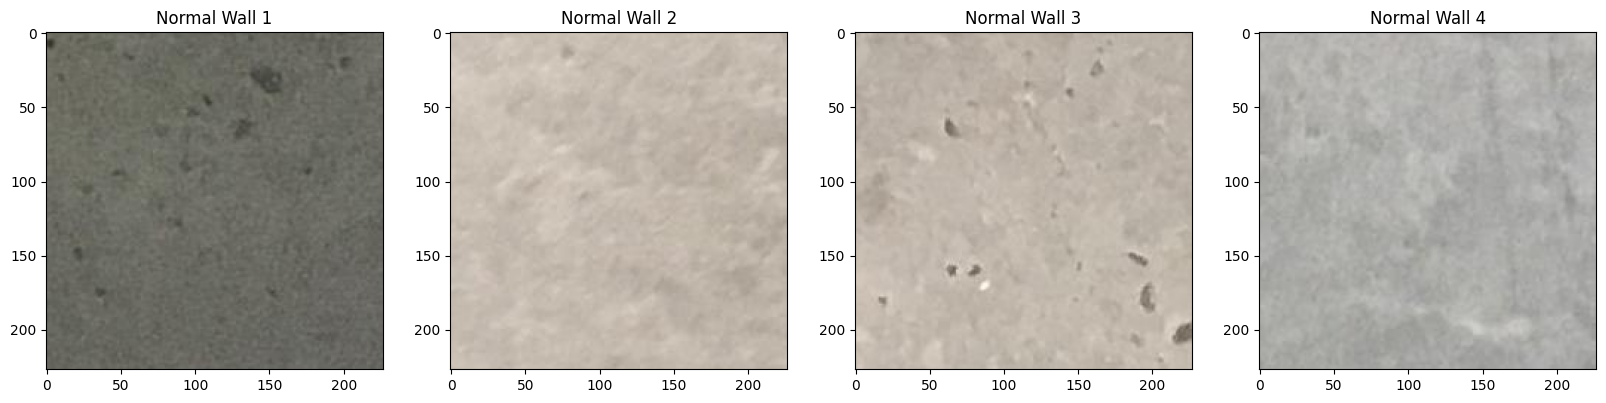

In [9]:
show_data(os.path.join(DS_PATH, "Negative"), title = "Normal Wall", n_plots = plots, n_plot_height = plot_height, n_plot_width = plot_width)

### Cracked Walls

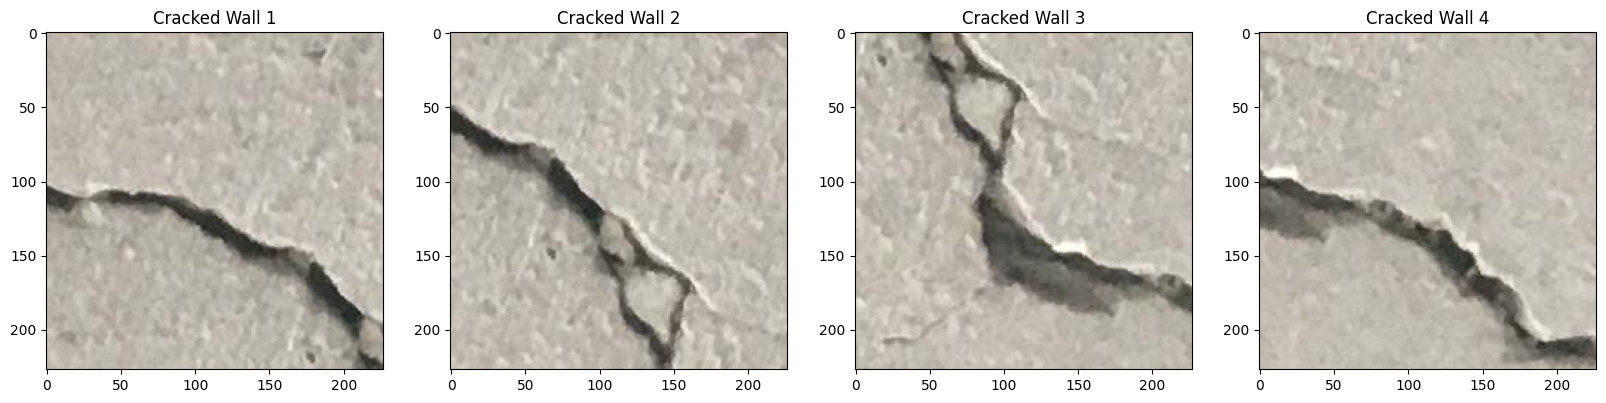

In [10]:
show_data(os.path.join(DS_PATH, "Positive"), title = "Cracked Wall", n_plots = plots, n_plot_height = plot_height, n_plot_width = plot_width)

## 6. Model Training

In [11]:
%%time
# Get the model, only train the classifier
model = get_model(device=device, fine_tune=True, n_classes=n_classes)

# Setup optimizer, scheduler and scaler
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2, eta_min=0, last_epoch=-1)
scaler = torch.cuda.amp.GradScaler(enabled=device == "cuda")

# Train the model
best_model_data, training_stats = train_model(model, optimizer, scheduler, scaler, (train_dl, valid_dl),
                                              device, epochs=epochs)
best_model, best_model_accuracy = best_model_data

# Save the trained model and print its validation accuracy
print(f"The best model has a validation accuracy of: {best_model_accuracy}")

----- ConcreteModel ----
New Classifier Stats: 
Input features 1° Linear:  512
Input features 2° Linear:  256
Input features 3° Linear:  85
Output 3° Linear:  2
------------------------
Train: [0][1/55]:	BT 6.354	ETA 0:05:49.444133	loss 0.717	
Train: [0][2/55]:	BT 3.325	ETA 0:02:59.571709	loss 0.872	
Train: [0][3/55]:	BT 2.316	ETA 0:02:02.723026	loss 0.780	
Train: [0][4/55]:	BT 2.039	ETA 0:01:46.030013	loss 0.792	
Train: [0][5/55]:	BT 1.907	ETA 0:01:37.235019	loss 0.775	
Train: [0][6/55]:	BT 1.819	ETA 0:01:30.967321	loss 0.736	
Train: [0][7/55]:	BT 1.776	ETA 0:01:27.024407	loss 0.718	
Train: [0][8/55]:	BT 1.729	ETA 0:01:22.973708	loss 0.703	
Train: [0][9/55]:	BT 1.701	ETA 0:01:19.936142	loss 0.687	
Train: [0][10/55]:	BT 1.681	ETA 0:01:17.325009	loss 0.664	
Train: [0][11/55]:	BT 1.655	ETA 0:01:14.467464	loss 0.648	
Train: [0][12/55]:	BT 1.634	ETA 0:01:11.881722	loss 0.636	
Train: [0][13/55]:	BT 1.621	ETA 0:01:09.694127	loss 0.620	
Train: [0][14/55]:	BT 1.663	ETA 0:01:09.833111	loss 0.60

## 7. Plot Training Results

### Prepare results data

In [24]:
train_results, valid_results = training_stats[0], training_stats[1]
train_loss = [epoch_result["loss"] for epoch_result in train_results]
valid_loss = [epoch_result["loss"] for epoch_result in valid_results]
train_accuracy = [epoch_result["accuracy"]["top1"] for epoch_result in train_results]
valid_accuracy = [epoch_result["accuracy"]["top1"] for epoch_result in valid_results]

### Plot Training Loss

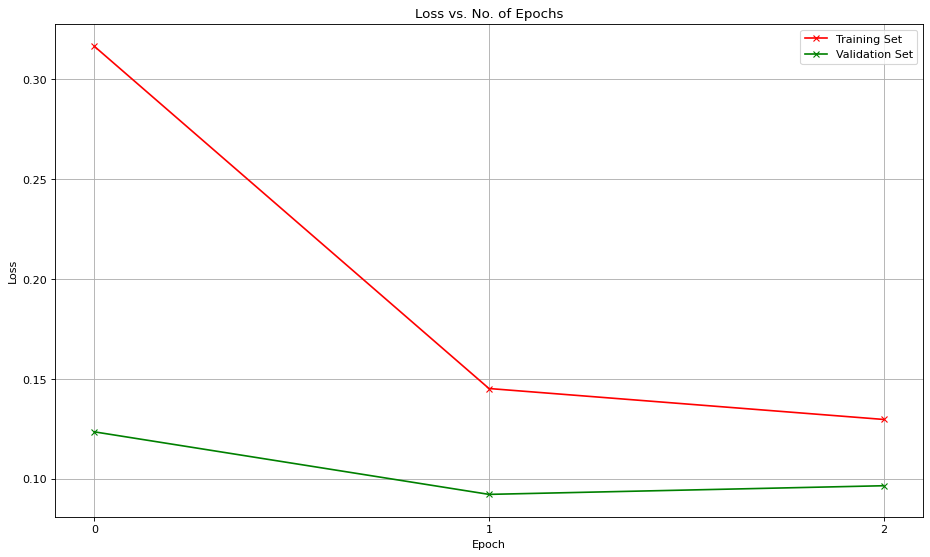

In [23]:
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_loss, '-rx')
plt.plot(valid_loss, '-gx')
plt.xlabel('Epoch')
plt.xticks(range(epochs))
plt.ylabel('Loss')
plt.legend(['Training Set', 'Validation Set'])
plt.title('Loss vs. No. of Epochs')
plt.grid()

### Plot Training Accuracy

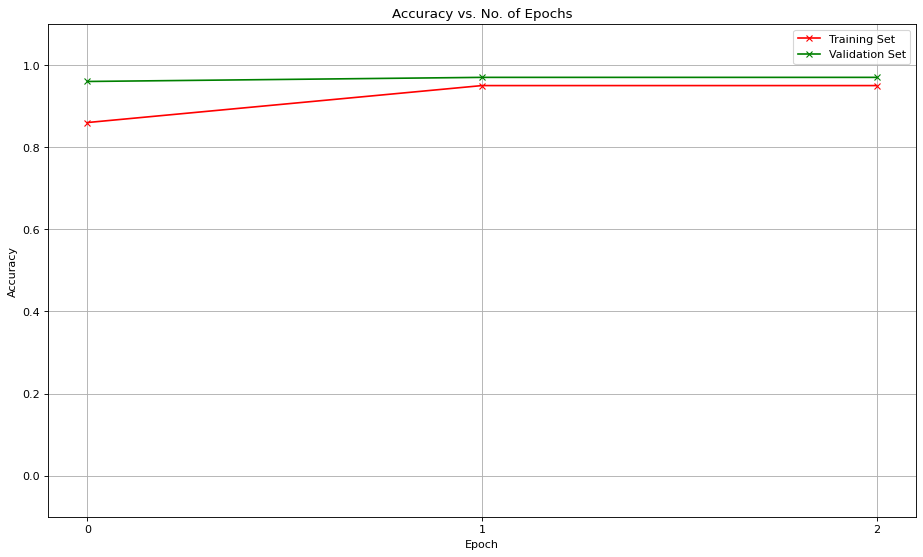

In [22]:
# Normalize with 2 floating digits
train_accuracy_normalized = np.array(np.round(train_accuracy, 2))
valid_accuracy_normalized = np.array(np.round(valid_accuracy, 2))

# Plot
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_accuracy_normalized, '-rx')
plt.plot(valid_accuracy_normalized, '-gx')
plt.xlabel('Epoch')
plt.xticks(range(epochs))
plt.ylabel('Accuracy')
plt.ylim(-0.1, 1.1)
plt.legend(['Training Set', 'Validation Set'])
plt.title('Accuracy vs. No. of Epochs')
plt.grid()

## 8. Save the Model

In [15]:
# Save
torch.save(model.state_dict(), MODEL_SAVE_PATH)
# Flush updates to google drive if we use it
if _USE_G_DRIVE:
  drive.flush_and_unmount()